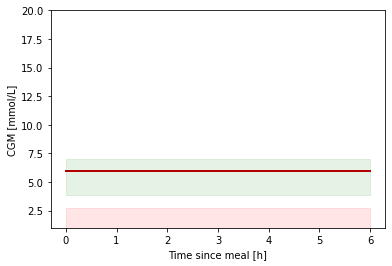

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

import DiabetesModels as Sim
import bayesoptlib as BO

from tqdm import tqdm


bounds = np.array([[0,700]]) # bounds for Bolus 

chgSeed = 100
np.random.seed(int(chgSeed+5))
# historical data
X_sample = np.random.uniform([0,0,6],[0,0,6],(1,3))


PatientNr = 2
patient = Sim.Patient(PatientNr)
patient.steadyState() # compute the basal insulin and steady-state 

patient.simulate(X_sample[0][0],X_sample[0][1],x0 = patient.xSS)
patient.plot_CGM()
Y_sample = patient.CGP

In [5]:
Y_sample

2.115330517350143e-27

100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


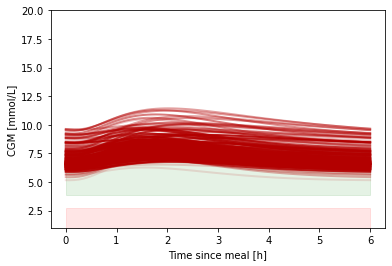

In [6]:
chgSeed = chgSeed+1
inputDim = 3  # bolus, meal, and initial glucose level

var0 = 4000
kernel =  GPy.kern.Matern52(inputDim,ARD=True,lengthscale=[150,5,5],variance=var0)

mf = GPy.core.Mapping(inputDim,1)


def prior_2d(x):
    y = 0.06*(x[:,0]-20*x[:,1])**2 + 5.5*x[:,1]**2  #stingray function as my prior
    return y.reshape(-1,1)

def prior(x):
    y = 0.06*(x[:,0]-15*x[:,1])**2 + 5.5*x[:,1]**2 + 6*60/5*(x[:,2]-6)**2   #stingray function as my prior + scaling due to initial glucose level
    return y.reshape(-1,1)


mf.f = prior
mf.update_gradients = lambda a,b: None

bolus_range = np.linspace(bounds[:, 0].T, bounds[:, 1].T, 1000).reshape(1000,-1)
meal_range = np.linspace(0, 20, 50).reshape(50,-1)

k=0
nTIR = []
nTBR = []
nMeal = []
CGPI = []
BG0 = []
xinit = patient.xSS

nMeals = 180
al = np.linspace(0,1,len(range(nMeals)))

for i in tqdm(range(nMeals)):
    k+=1
    np.random.seed(int(i+75))
    Meal = np.array([np.random.uniform(5,20),xinit[10]]).reshape(-1,2)  # Meal and the start glucose level
    CBO = BO.contextual_bayesian_optimization(X_sample,Y_sample.reshape(-1,1),Meal,bounds,mf,
                                  kernel, X_grid = bolus_range)

    CBO.fit_gp()
    CBO.query_next_UCB()
    Bolus = CBO.X_next[0][0]

    # Baseline - with no learning - using only prior mean
    #Bolus = np.argmin(0.06*(bolus_range-20*Meal[0][0])**2 + 5.5*Meal[0][0]**2 + (xinit[10]-6))

    patient.simulate(Bolus,Meal[0][0],x0 = xinit)
    Y_next = patient.CGP 
    xinit = patient.xEnd
    CGPI.append(patient.CGP.tolist())
    BG0.append(xinit[10])
    
    X_sample = np.vstack((X_sample, CBO.X_next))
    Y_sample = np.vstack((Y_sample, Y_next.tolist()))

    CGMi = np.array(patient.CGM).reshape(-1,1)
    x = np.where(CGMi<=3.9)
    y = np.where(CGMi>10)
    TAR = len(y[0])/len(CGMi)*100
    TBR = len(x[0])/len(CGMi)*100
    TIR = 100 - TAR - TBR

    nTIR.append(TIR)
    nTBR.append(TBR)
    nMeal.append(Meal)
    
    time = np.linspace(0,patient.nSim,patient.nSim)*patient.Ts/60

    if i ==0:
        plt.fill_between(time,3.9+0*time,7+0*time,color='g',alpha=0.1)
        plt.fill_between(time,0+0*time,2.7+0*time,color='r',alpha=0.1)
    plt.plot(time,patient.CGM,color=(0.7,0.0,0.0),linewidth=2,label='CGM',alpha=np.asscalar(al[i]))

plt.xlabel('Time since meal [h]')
plt.ylabel('CGM [mmol/L]')
plt.ylim(1,20)
plt.show()

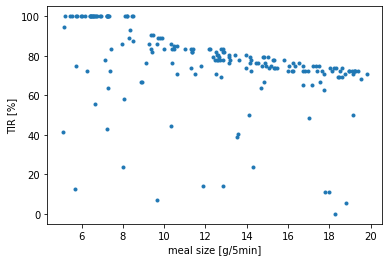

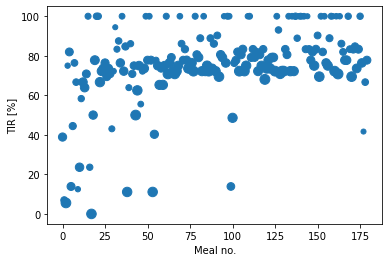

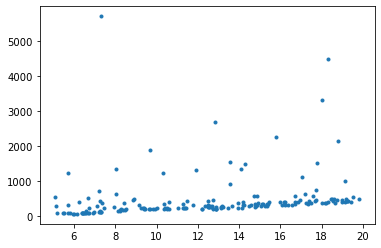

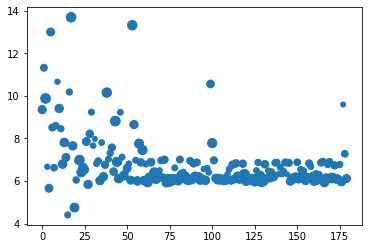

In [ ]:
nMeal = np.array(nMeal).reshape(-1,2)
plt.plot(nMeal[:,0],nTIR,'.')
plt.xlabel('meal size [g/5min]')
plt.ylabel('TIR [%]')
plt.show()

plt.scatter(range(nMeals),nTIR,s=nMeal[:,0]*5)
plt.ylabel('TIR [%]')
plt.xlabel('Meal no.')
plt.show()

plt.plot(nMeal[:,0],CGPI,'.')
plt.show()

plt.scatter(range(nMeals),BG0,s=nMeal[:,0]*5)
plt.show()


{'whiskers': [<matplotlib.lines.Line2D at 0x7f01eb19b190>,
 'caps': [<matplotlib.lines.Line2D at 0x7f01eb19b8b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f01eb1cadc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f01eb19bfd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f01eb1cf3a0>],
 'means': []}

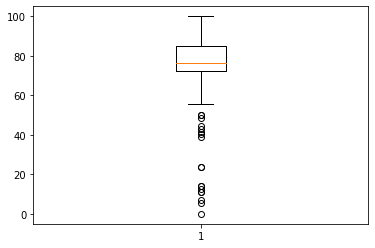

In [ ]:
plt.boxplot(nTIR)